In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import ast
from constants import *
from sft import *
from utils import *
from datasets import load_dataset, concatenate_datasets, Dataset, DatasetDict
from collections import Counter
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [3]:
def error_type_map(example):
    # Any combination of error types is mapped into the same order.
    label_map = {
        "['extrinsic-NP']" : "['extrinsic-NP']",
        "['extrinsic-predicate']" : "['extrinsic-predicate']",
        "['intrinsic-NP']" : "['intrinsic-NP']",
        "['intrinsic-predicate']" : "['intrinsic-predicate']",
        'correct' : "['correct']",
        "['correct']" : "['correct']",

        "['extrinsic-NP', 'intrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP']",
        "['extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-predicate']", 
        "['intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate']",
        "['extrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-NP']" : "['intrinsic-predicate', 'extrinsic-NP']",
        "['extrinsic-NP', 'intrinsic-predicate']" : "['intrinsic-predicate', 'extrinsic-NP']",
        "['extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'intrinsic-predicate']" : "['intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'intrinsic-NP']" : "['intrinsic-NP', 'intrinsic-predicate']",

        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['extrinsic-NP', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['extrinsic-predicate', 'intrinsic-NP', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['extrinsic-predicate', 'extrinsic-NP', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
         
        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'extrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",

        "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'intrinsic-NP', 'extrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-NP', 'intrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'extrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",

        "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'intrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",

        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        }
    
    try:
        example['error_type'] = label_map[example['error_type']]
        return example
    
    except KeyError:
        return

In [7]:
def make_binary_dataset(dataset, error_type='correct'):
    # Map dataset into error / not_error
    def map_to_binary(x):
        # Assume error_type is a list, convert to single string if needed
        x['error_type'] = 'correct' if error_type in x['error_type'] else 'incorrect'
        return x

    # Apply the binary mapping
    binary_dataset = dataset.map(map_to_binary)

    # Count the number of 'correct' samples
    num_correct = binary_dataset.filter(lambda x: x['error_type'] == 'correct').num_rows

    # Undersample to ensure balanced classes
    binary_dataset = undersampling(binary_dataset, error_types=['correct', 'incorrect'], n=num_correct)

    return binary_dataset

def make_binary_dataset_intrinsic_extrinsic(dataset):
    def map_to_binary(x):
        # Assume error_type is a list, convert to single string if needed
        x['error_type'] = '' if error_type in x['error_type'] else 'incorrect'
        return x
    
    


def undersampling(dataset, error_types=DATASET_LABELS["Lislaam/AggreFact"].values(),
                    n=400):
    def sample_class(dataset, error_type, n):
        filtered = dataset.filter(lambda x: x['error_type'] == error_type)
        return filtered.shuffle(seed=42).select(range(min(n, len(filtered))))

    # Sample 400 examples from each class
    sampled_dataset = Dataset.from_dict({
        'doc': [],
        'summ': [],
        'error_type': []
    })

    for error_type in error_types:
        sampled = sample_class(dataset, error_type, n)
        sampled_dataset = concatenate_datasets([sampled_dataset, sampled])

    # Shuffle the final dataset
    sampled_dataset = sampled_dataset.shuffle(seed=42)

    return sampled_dataset


def oversampling(dataset, error_types=DATASET_LABELS["Lislaam/AggreFact"].values(), n=2330): #error_types=['correct', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP', 'extrinsic-predicate'], n=2330):
    def replicate_class(dataset, error_type, n):
        filtered = dataset.filter(lambda x: x['error_type'] == error_type)
        num_examples = len(filtered)
        
        if num_examples == 0:
            return filtered  # Return empty dataset if no examples
        
        # Calculate how many times to replicate the dataset
        num_repeats = n // num_examples
        num_remaining = n % num_examples
        
        # Repeat the dataset and select the needed number of examples
        replicated = concatenate_datasets([filtered] * num_repeats)
        remaining = filtered.shuffle(seed=42).select(range(num_remaining))
        
        # Concatenate the replicated examples with the additional ones needed
        return concatenate_datasets([replicated, remaining])

    # Initialize an empty dataset for oversampling
    oversampled_dataset = Dataset.from_dict({
        'doc': [],
        'summ': [],
        'error_type': []
    })

    for error_type in error_types:
        oversampled = replicate_class(dataset, error_type, n)
        oversampled_dataset = concatenate_datasets([oversampled_dataset, oversampled])

    # Shuffle the final dataset
    oversampled_dataset = oversampled_dataset.shuffle(seed=42)
    
    return oversampled_dataset

In [8]:
dataset = load_dataset('Lislaam/AggreFact', split=['validation[:]', 'test[:]'])
dataset = concatenate_datasets([dataset[0], dataset[1]]) # Turn into one dataset to make new split
dataset = dataset.filter(lambda x: error_type_map(x) is not None)
dataset = dataset.map(error_type_map)

tokenizer = AutoTokenizer.from_pretrained('mistralai/Mistral-7B-Instruct-v0.3')

# Convert the dataset to a pandas DataFrame
df = dataset.to_pandas()
df['doc_length'] = df['doc'].apply(len)
df['summ_length'] = df['summ'].apply(len)

In [ ]:
# Define the two origins you want to compare
origin_1 = 'xsum'  # Replace with the actual value for the first origin
origin_2 = 'cnndm'  # Replace with the actual value for the second origin

# Filter the DataFrame for the two origins
df_origin_1 = df[df['origin'] == origin_1]
df_origin_2 = df[df['origin'] == origin_2]

# Plot histograms of document length for each origin
plt.figure(figsize=(12, 6))
plt.hist(df_origin_1['doc_length'], bins=30, alpha=0.5, label=origin_1)
plt.hist(df_origin_2['doc_length'], bins=30, alpha=0.5, label=origin_2)

# Add labels and title
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.title('Histogram of Document Length by Origin')
plt.legend(loc='upper right')
plt.grid(alpha=0.5)

# Show the plot
plt.show()

# =============================================================================
# Plot histograms of document length for each origin
plt.figure(figsize=(12, 6))
plt.hist(df_origin_1['summ_length'], bins=30, alpha=0.5, label=origin_1)
plt.hist(df_origin_2['summ_length'], bins=30, alpha=0.5, label=origin_2)

# Add labels and title
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.title('Histogram of SUMMARY Length by Origin')
plt.legend(loc='upper right')
plt.grid(alpha=0.5)

# Show the plot
plt.show()

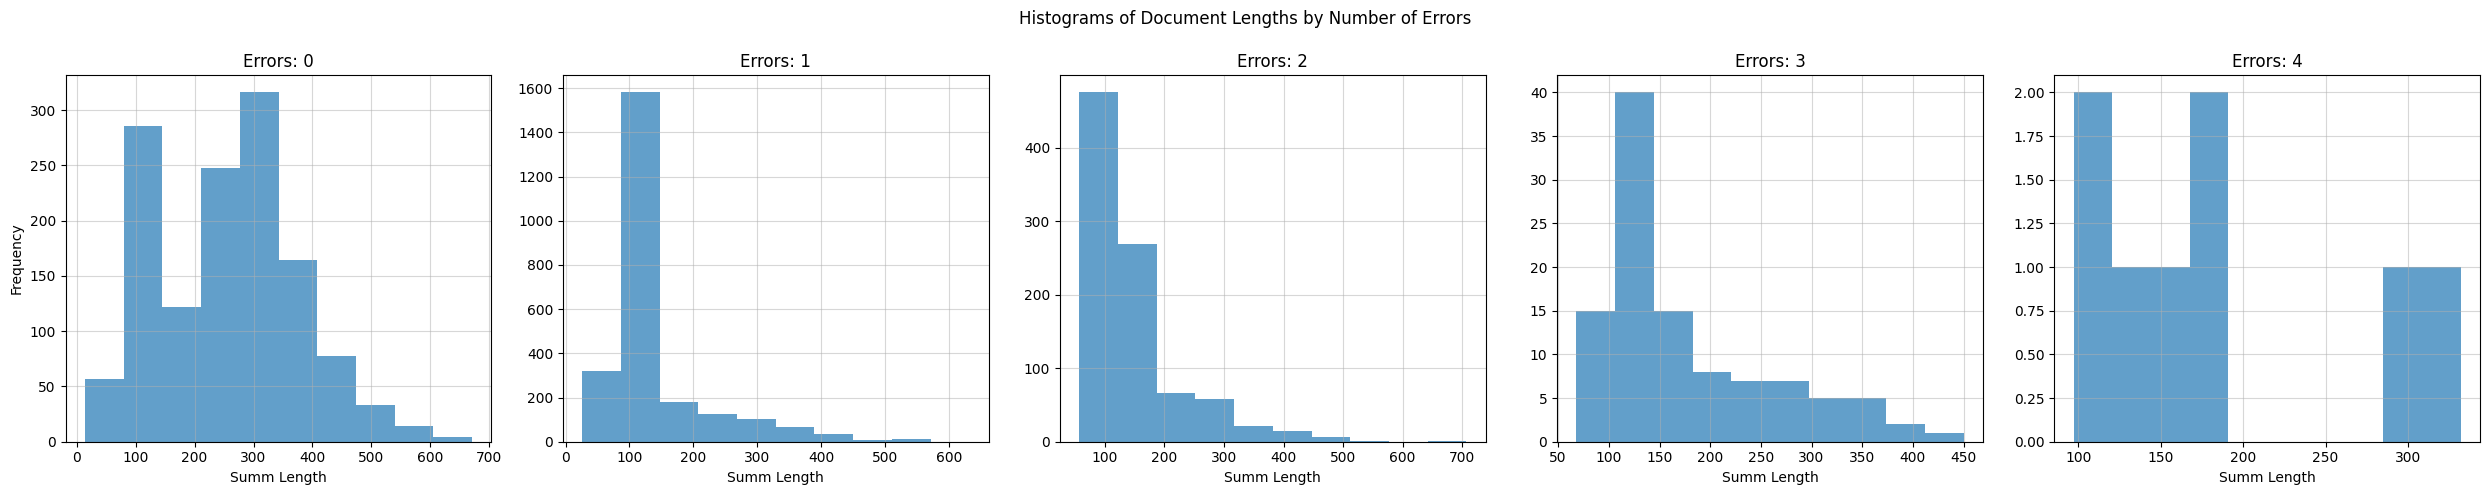

In [11]:
# Get num of errors vs length of doc

df['error_type_list'] = df['error_type'].apply(lambda x: ast.literal_eval(x))
df['num_errors'] = df['error_type_list'].apply(lambda x: len(x) if x != ['correct'] else 0)

# Define the range of unique error counts you want to plot
unique_error_counts = range(5)  # Assuming 'num_errors' ranges from 0 to 4

# Create subplots with 1 row and 5 columns (one for each error count)
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=False)  # Share y-axis for better comparison

# Loop over each unique error count and corresponding subplot axis
for num_error, ax in zip(unique_error_counts, axes):
    # Filter the dataframe to include only rows with the current number of errors
    subset = df[df['num_errors'] == num_error]
    
    # Plot the histogram for the current subset of documents
    ax.hist(subset['summ_length'], bins=10, alpha=0.7)
    
    # Set title and labels for each subplot
    ax.set_title(f'Errors: {num_error}')
    ax.set_xlabel('Summ Length')
    ax.grid(alpha=0.5)
    if num_error == 0:
        ax.set_ylabel('Frequency')  # Only set y-axis label on the first subplot

# Set a common title for the entire figure
fig.suptitle('Histograms of Document Lengths by Number of Errors')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to make room for the main title

# Show the plot
plt.show()

In [ ]:
# Function to tokenize and calculate length
def tokenize_length(text):
    tokens = tokenizer.tokenize(text)
    return len(tokens)

# Apply tokenization length calculation for each document
df['tokenized_length'] = df['doc'].apply(tokenize_length)
df['tokenized_summ_length'] = df['summ'].apply(tokenize_length)

# Separate the data based on origin
origin1_data = df[df['origin'] == 'xsum']
origin2_data = df[df['origin'] == 'cnndm']

# Plot histograms of tokenized lengths for each origin on the same axis
plt.figure(figsize=(10, 6))

plt.hist(origin1_data['tokenized_length'], alpha=0.5, color='blue', label='xsum')
plt.hist(origin2_data['tokenized_length'], alpha=0.5, color='orange', label='cnndm')

plt.title('Tokenized Document Lengths by Origin')
plt.xlabel('Tokenized Document Length')
plt.ylabel('Frequency')
plt.legend(title='Origin')
plt.grid(alpha=0.5)

plt.show()

# =============================================================================
# Plot histograms of tokenized lengths for each origin on the same axis
plt.figure(figsize=(10, 6))

plt.hist(origin1_data['tokenized_summ_length'], alpha=0.5, color='blue', label='xsum')
plt.hist(origin2_data['tokenized_summ_length'], alpha=0.5, color='orange', label='cnndm')

plt.title('Tokenized Document Lengths by Origin')
plt.xlabel('Tokenized Document Length')
plt.ylabel('Frequency')
plt.legend(title='Origin')
plt.grid(alpha=0.5)

plt.show()

In [ ]:
binary_dataset = make_binary_dataset(dataset, error_type='correct')

In [ ]:
from collections import Counter

Counter(binary_dataset['error_type'])
Counter(dataset['origin'])

In [ ]:
# Function to tokenize dataset and extract vocabulary with frequencies
def extract_vocabulary_with_frequencies(dataset, tokenizer, text_column='text'):
    vocab_counter = Counter()
    for example in dataset[text_column]:
        tokens = tokenizer.tokenize(example)
        vocab_counter.update(tokens)
    return vocab_counter

# Extract vocabularies
vocab1 = extract_vocabulary_with_frequencies(df[df['origin'] == 'xsum'], tokenizer, text_column='doc')
vocab2 = extract_vocabulary_with_frequencies(df[df['origin'] == 'cnndm'], tokenizer, text_column='doc')

# Convert Counter objects to regular dictionaries for plotting
vocab1_dict = dict(vocab1)
vocab2_dict = dict(vocab2)

# Create lists of frequencies for the most common tokens
freq1 = [count for token, count in vocab1.most_common(50)]  # Top 50 tokens
freq2 = [count for token, count in vocab2.most_common(50)]

plt.figure(figsize=(12, 6))

# Plot histograms for both datasets
plt.hist(freq1, bins=20, alpha=0.5, label='xsum')
plt.hist(freq2, bins=20, alpha=0.5, label='cnndm')

plt.xlabel('Token Frequency')
plt.ylabel('Number of Tokens')
plt.title('Token Frequency Distribution of SOURCE TEXT')
plt.legend()
plt.show()

# =============================================================================
# Extract vocabularies
vocab10 = extract_vocabulary_with_frequencies(df[df['origin'] == 'xsum'], tokenizer, text_column='summ')
vocab20 = extract_vocabulary_with_frequencies(df[df['origin'] == 'cnndm'], tokenizer, text_column='summ')

# Convert Counter objects to regular dictionaries for plotting
vocab10_dict = dict(vocab10)
vocab20_dict = dict(vocab20)

# Create lists of frequencies for the most common tokens
freq1 = [count for token, count in vocab10.most_common(50)]  # Top 50 tokens
freq2 = [count for token, count in vocab20.most_common(50)]

plt.figure(figsize=(12, 6))

# Plot histograms for both datasets
plt.hist(freq1, bins=20, alpha=0.5, label='xsum')
plt.hist(freq2, bins=20, alpha=0.5, label='cnndm')

plt.xlabel('Token Frequency')
plt.ylabel('Number of Tokens')
plt.title('Token Frequency Distribution of SUMMARIES')
plt.legend()
plt.show()

In [ ]:
# Prepare data for Venn diagram
vocab1_set = set(vocab1.keys())
vocab2_set = set(vocab2.keys())

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn2([vocab1_set, vocab2_set], ('XSUM', 'CNN/DM'))
plt.title('Venn Diagram of DOCUMENT Token Sets')
plt.show()

print(vocab1.keys())

# =========================================================
# Prepare data for Venn diagram
vocab10_set = set(vocab10.keys())
vocab20_set = set(vocab20.keys())

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn2([vocab10_set, vocab20_set], ('XSUM', 'CNN/DM'))
plt.title('Venn Diagram of SUMMARY Token Sets')
plt.show()

print(vocab1.keys())

In [ ]:
from wordcloud import WordCloud

# Create word clouds
wordcloud1 = WordCloud(width=800, height=400).generate_from_frequencies(vocab1_dict)
wordcloud2 = WordCloud(width=800, height=400).generate_from_frequencies(vocab2_dict)

plt.figure(figsize=(16, 8))

# Plot word cloud for Dataset 1
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Word Cloud for Dataset 1')
plt.axis('off')

# Plot word cloud for Dataset 2
plt.subplot(1, 2, 2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Word Cloud for Dataset 2')
plt.axis('off')

plt.show()

# Regression Analysis

In [ ]:
# Example: Load a tokenizer (if you're using a tokenizer for length calculation)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Adjust this to your model

# Add a new column with the tokenized length of each summary
def get_summary_length(example):
    example['summary_length'] = len(tokenizer.tokenize(example['summary']))
    return example

# Apply the function to add summary length column
dataset = dataset.map(get_summary_length)

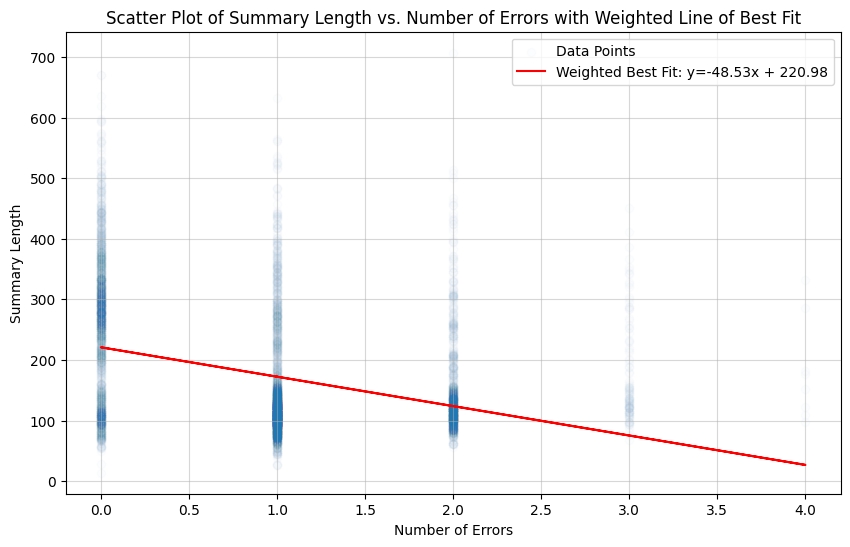

In [13]:
# Calculate the frequency of each error count
error_counts = df['num_errors'].value_counts()

# Create a weight array where each weight corresponds to the frequency of the error count
weights = df['num_errors'].map(error_counts)

# Perform weighted linear regression using np.polyfit with the 'w' parameter
slope, intercept = np.polyfit(df['num_errors'], df['summ_length'], 1)#, w=weights)
line = slope * df['num_errors'] + intercept

# Create the scatter plot with swapped axes
plt.figure(figsize=(10, 6))
plt.scatter(df['num_errors'], df['summ_length'], alpha=0.01, label='Data Points')

# Plot the weighted line of best fit with swapped axes
plt.plot(df['num_errors'], line, color='red', label=f'Weighted Best Fit: y={slope:.2f}x + {intercept:.2f}')

# Adding labels and title
plt.ylabel('Summary Length')
plt.xlabel('Number of Errors')
plt.title('Scatter Plot of Summary Length vs. Number of Errors with Weighted Line of Best Fit')
plt.grid(alpha=0.5)
plt.legend()

# Show the plot
plt.show()

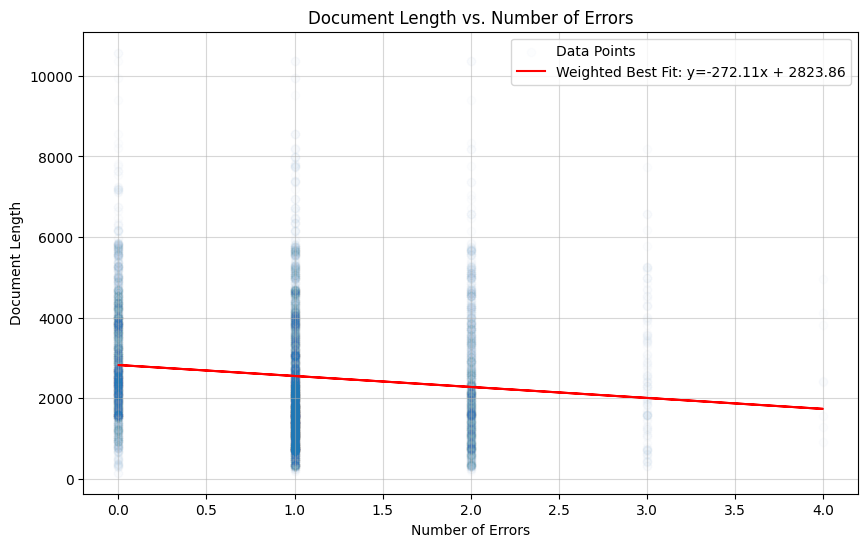

In [12]:
# Calculate the frequency of each error count
error_counts = df['num_errors'].value_counts()

# Create a weight array where each weight corresponds to the frequency of the error count
weights = df['num_errors'].map(error_counts)

# Perform weighted linear regression using np.polyfit with the 'w' parameter
slope, intercept = np.polyfit(df['num_errors'], df['doc_length'], 1)#, w=weights)
line = slope * df['num_errors'] + intercept

# Create the scatter plot with swapped axes
plt.figure(figsize=(10, 6))
plt.scatter(df['num_errors'], df['doc_length'], alpha=0.01, label='Data Points')

# Plot the weighted line of best fit with swapped axes
plt.plot(df['num_errors'], line, color='red', label=f'Weighted Best Fit: y={slope:.2f}x + {intercept:.2f}')

# Adding labels and title
plt.ylabel('Document Length')
plt.xlabel('Number of Errors')
plt.title('Document Length vs. Number of Errors')
plt.grid(alpha=0.5)
plt.legend()

# Show the plot
plt.show()

# What % of the data is annotated?

In [ ]:
dataset = load_dataset('Lislaam/AggreFact', split=['validation[:]', 'test[:]'])
dataset = concatenate_datasets([dataset[0], dataset[1]]) # Turn into one dataset to make new split
dataset = dataset.filter(lambda x: error_type_map(x) is not None)
dataset = dataset.map(error_type_map)
dataset

Dataset({
    features: ['dataset', 'origin', 'id', 'doc', 'summ', 'model_name', 'cut', 'error_type', 'annotated_span'],
    num_rows: 4774
})

In [ ]:
len(dataset.filter(lambda x: x['error_type'] == "['correct']")), len(dataset.filter(lambda x: x['annotated_span'] != None))

Filter: 100%|██████████| 4774/4774 [00:00<00:00, 114946.08 examples/s]


(1322, 1958)

27.7% of the dataset is 'correct' summaries.
56.7% of incorrect summaries have annotated spans. That leaves 1494 unannotated summaries.

In [3]:
from datasets import load_dataset

# Load the CSV file into a dataset
dataset = load_dataset('Lislaam/AggreFact', split=['validation[:]', 'test[:]'])
dataset = concatenate_datasets([dataset[0], dataset[1]]) # Turn into one dataset to make new split
dataset = dataset.filter(lambda x: error_type_map(x) is not None)
dataset = make_binary_dataset(dataset, error_type='correct')
#dataset = load_dataset('csv', data_files='rag_test_data.csv')
dataset = dataset.shuffle(seed=42)

# Save the dataset to disk
dataset.save_to_disk('correct_incorrect_data')

Saving the dataset (1/1 shards): 100%|██████████| 2644/2644 [00:00<00:00, 108176.75 examples/s]


In [8]:
from datasets import Dataset

dataset = Dataset.from_file('correct_incorrect_data/data-00000-of-00001.arrow')

In [5]:
import pickle

with open('rag_test_data.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [2]:
# Identify blank columns
columns_to_remove = []
for column in dataset.column_names:
    if all(x is None or x == "" for x in dataset[column]):
        columns_to_remove.append(column)

# Remove blank columns
dataset = dataset.remove_columns(columns_to_remove)

sum([1 for i in dataset['error_type'] if i == 'correct'])

NameError: name 'dataset' is not defined

In [14]:
import numpy as np
from sklearn.metrics import f1_score
y_true = ['0', '1', '2', '0', '1', '2']
y_pred = ['0 wgwgrr', '2rrr', '1 gwrwg', '0 rwg', '0 wgrwr', '1 wgrwr']
print(f1_score(y_true, y_pred, average='macro'))
print(f1_score(y_true, y_pred, average='micro'))
print(f1_score(y_true, y_pred, average='weighted'))
print(f1_score(y_true, y_pred, average=None))

0.0
0.0
0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
